 <div align="center"> <span style="color:#blue"> <h2> Mask Detection  <h2></span></div>


In [ ]:
# dataset link kaggle : https://www.kaggle.com/datasets/andrewmvd/face-mask-detection
# annotations = "/kaggle/input/face-mask-detection/annotations/"
# images = "/kaggle/input/face-mask-detection/images/"

In [2]:
pip install xmltodict

In [3]:
!pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/cu110/torch_stable.html


Looking in links: https://download.pytorch.org/whl/cu110/torch_stable.html


In [4]:
import torch
torch.version.cuda


'12.1'

In [5]:
torch.cuda.is_available()


True

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image


import os

import seaborn as sns
import sys

import warnings
warnings.filterwarnings("ignore")

In [7]:
import torch
from torchvision import datasets,transforms,models
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import torchvision.models as models


import torch.optim as optim

In [8]:
import xmltodict

In [9]:
from collections import Counter

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### import folders


In [11]:
annotations = "/content/drive/MyDrive/annotations/"

images = "/content/drive/MyDrive/images/"


#### List of names :  image and annotation

In [12]:

image_names = []
annotation_names = []

for dirname, _, filenames in os.walk(annotations):
    for filename in filenames:
        if filename[-3:] == "xml":
            annotation_names.append(filename)

            image_path = os.path.join(annotations, filename[:-4] + ".png")

            image_names.append(filename[:-4] + ".png")


In [13]:
print(len(image_names))

853


#### function :  Create Dataset

In [14]:
class Creation_Dataset:
    def __init__(self, image_list, annotation_dir, images_dir, labels, transform):
        self.image_list = image_list
        self.annotation_dir = annotation_dir
        self.images_dir = images_dir
        self.labels = labels
        self.transform = transform
        self.dataset = self._create_dataset()
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return self.dataset[index]

    def _create_dataset(self):
        dataset = []

        for img_name in self.image_list:
            annotation_path = os.path.join(self.annotation_dir, img_name[:-4] + ".xml")
            with open(annotation_path) as fd:
                doc = xmltodict.parse(fd.read())

            objects = doc["annotation"]["object"]
            if not isinstance(objects, list):
                objects = [objects]

            for obj in objects:
                x, y, w, h = map(int, obj["bndbox"].values())
                label = self.labels[obj["name"]]
                img_path = os.path.join(self.images_dir, img_name)
                img = Image.open(img_path).convert("RGB")
                cropped_img = transforms.functional.crop(img, y, x, h-y, w-x)
                transformed_img = self.transform(cropped_img)
                label_tensor = torch.tensor(label)
                dataset.append((transformed_img, label_tensor))

        return dataset

labels = {"with_mask": 0, "without_mask": 1, "mask_weared_incorrect": 2}
transform = transforms.Compose([transforms.Resize((224, 224)),  transforms.ToTensor()])



### Our dataset :

In [15]:
data = Creation_Dataset(image_names, annotations, images, labels, transform)

In [16]:
data[2]

(tensor([[[0.7216, 0.7216, 0.7216,  ..., 0.1725, 0.1725, 0.1725],
          [0.7216, 0.7216, 0.7216,  ..., 0.1725, 0.1725, 0.1725],
          [0.7216, 0.7216, 0.7216,  ..., 0.1725, 0.1725, 0.1725],
          ...,
          [0.6353, 0.6353, 0.6353,  ..., 0.1098, 0.1098, 0.1098],
          [0.6353, 0.6353, 0.6353,  ..., 0.1098, 0.1098, 0.1098],
          [0.6353, 0.6353, 0.6353,  ..., 0.1098, 0.1098, 0.1098]],
 
         [[0.4902, 0.4902, 0.4902,  ..., 0.0314, 0.0314, 0.0314],
          [0.4902, 0.4902, 0.4902,  ..., 0.0314, 0.0314, 0.0314],
          [0.4902, 0.4902, 0.4902,  ..., 0.0314, 0.0314, 0.0314],
          ...,
          [0.3333, 0.3333, 0.3333,  ..., 0.0235, 0.0235, 0.0235],
          [0.3333, 0.3333, 0.3333,  ..., 0.0235, 0.0235, 0.0235],
          [0.3333, 0.3333, 0.3333,  ..., 0.0235, 0.0235, 0.0235]],
 
         [[0.5647, 0.5647, 0.5647,  ..., 0.0353, 0.0353, 0.0353],
          [0.5647, 0.5647, 0.5647,  ..., 0.0353, 0.0353, 0.0353],
          [0.5647, 0.5647, 0.5647,  ...,

# Data visualization :

In [17]:
labels_counter = Counter()

for idx in range(len(data)):
    _, label = data[idx]
    labels_counter[label.item()] += 1

labels_counter

Counter({2: 123, 0: 3232, 1: 717})

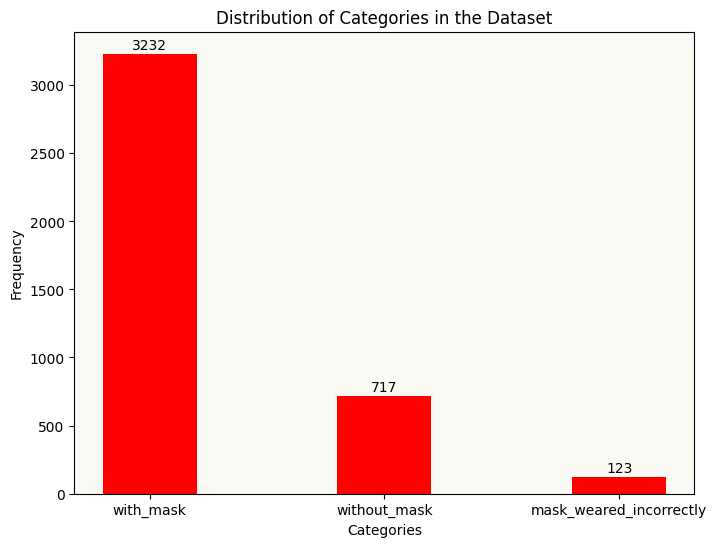

In [18]:
label_names = ['with_mask', 'without_mask', 'mask_weared_incorrectly']
frequencies = [3232, 717, 123]
label_values=[0, 1, 2]
plt.figure(figsize=(8, 6))
background_color = '#faf9f4'
plt.gca().set_facecolor(background_color)
plt.bar(label_values, frequencies, color='red', width=0.4)
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title('Distribution of Categories in the Dataset')

# Replace numerical labels with category names on the x-axis
plt.xticks(label_values, label_names)

# Add labels on top of the bars
for i, v in enumerate(frequencies):
    plt.text(i, v + 10, str(v), ha='center', va='bottom')

plt.show()


In [20]:
def visualize_bounding_boxes(dataset, indices, path_annotations, path_image):
    for idx in indices:
        img_name = dataset.image_list[idx]
        with open(os.path.join(path_annotations, img_name[:-4] + ".xml")) as fd:
            doc = xmltodict.parse(fd.read())

        image = plt.imread(os.path.join(path_image, img_name))
        fig, ax = plt.subplots(1)
        ax.axis("off")
        fig.set_size_inches(10, 5)

        temp = doc["annotation"]["object"]
        if isinstance(temp, list):
            for i in range(len(temp)):
                class_name = temp[i]["name"]
                x, y, w, h = list(map(int, temp[i]["bndbox"].values()))

                edgecolor = {"with_mask": "g", "without_mask": "r", "mask_weared_incorrect": "o"}[class_name]
                mpatch = mpatches.Rectangle((x, y), w - x, h - y, linewidth=1, edgecolor=edgecolor, facecolor="none", lw=2)
                ax.add_patch(mpatch)

                rx, ry = mpatch.get_xy()
                ax.annotate(class_name, (rx, ry), color=edgecolor, weight='bold', fontsize=10, ha='left', va='baseline')
        else:
            class_name = temp["name"]
            x, y, w, h = list(map(int, temp["bndbox"].values()))
            edgecolor = {"with_mask": "g", "without_mask": "r", "mask_weared_incorrect": "y"}[class_name]
            mpatch = mpatches.Rectangle((x, y), w - x, h - y, linewidth=1, edgecolor=edgecolor, facecolor="none", )
            ax.add_patch(mpatch)

        ax.imshow(image)
        ax.add_patch(mpatch)
        plt.show()



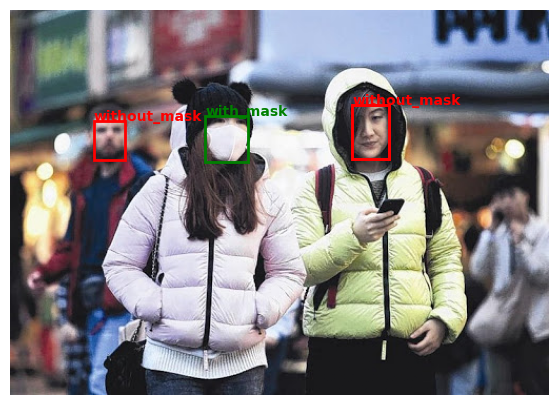

In [21]:
indices_to_visualize = [1]

visualize_bounding_boxes(data, indices_to_visualize, annotations, images)


## split :

In [22]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
# 80% train set 20% test set
test_size = 0.2

train_set, test_set = train_test_split(data, test_size=test_size, random_state=42)



### Create DataLoade

In [23]:
train_dataloader = DataLoader(dataset=train_set, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=test_set, batch_size=32, shuffle=False)

# modeling :

In [24]:
class MaskDetectionResNet(nn.Module):
    def __init__(self, num_classes):
        super(MaskDetectionResNet, self).__init__()
        # Charger le modèle ResNet-50 pré-entraîné
        resnet = models.resnet50(pretrained=True)

        # Supprimer la couche de classification existante
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)

        # Ajouter une nouvelle couche de classification adaptée à votre tâche
        self.fc = nn.Linear(resnet.fc.in_features, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [25]:
num_classes = 3

model = MaskDetectionResNet(num_classes)



In [34]:
model = model.cuda()


In [26]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [35]:
# Fonction d'entraînement
def train_model(model, train_loader, criterion, optimizer, num_epochs=1):
    model.train()
    for epoch in range(1, num_epochs + 1):  # Fix the range
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):

            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 20 == 19:
                print("Epoch {}, batch {}, training loss {}".format(epoch, i+1, running_loss/20))
                running_loss = 0.0  # Réinitialiser ici pour la prochaine moyenne



In [36]:
train_model(model, train_dataloader, criterion, optimizer)


Epoch 1, batch 20, training loss 0.48836352601647376
Epoch 1, batch 40, training loss 0.35700457617640496
Epoch 1, batch 60, training loss 0.28341849707067013
Epoch 1, batch 80, training loss 0.2573337249457836
Epoch 1, batch 100, training loss 0.295534810423851


### **Testing** :

In [37]:
def make_predictions(model, dataloader):
    model.eval()  # Mettez le modèle en mode évaluation
    predictions = []

    with torch.no_grad():
        for inputs, _ in dataloader:
            if torch.cuda.is_available():
                inputs = inputs.cuda()

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())

    return predictions



In [38]:
test_predictions = make_predictions(model, test_dataloader)

In [39]:
# Evaluation
def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    average_loss = total_loss / len(test_loader)
    accuracy = correct_predictions / total_samples

    return average_loss, accuracy

# Utiliser la fonction pour évaluer le modèle
test_loss, test_accuracy = evaluate_model(model, test_dataloader, criterion)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")


Test Loss: 0.2251, Test Accuracy: 92.76%


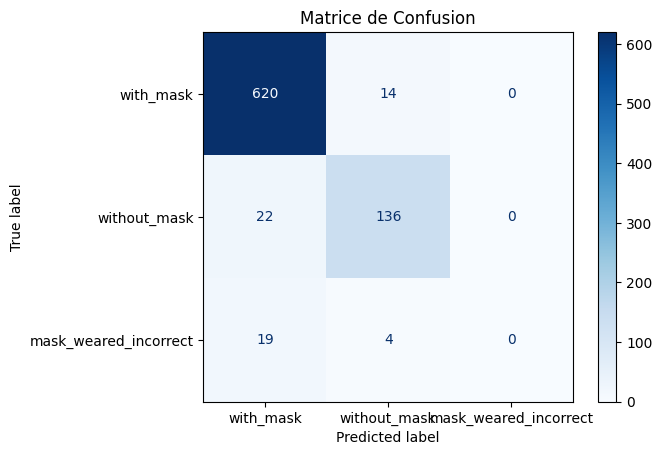

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

true_labels = []
for _, labels in test_dataloader:
    true_labels.extend(labels.cpu().numpy())


# Calculer la matrice de confusion
conf_matrix = confusion_matrix(true_labels, test_predictions)

# Afficher la matrice de confusion
labels = ["with_mask", "without_mask", "mask_weared_incorrect"]
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')
plt.title('Matrice de Confusion')
plt.show()
